# Forearm Pulse Analysis

### Objective: 
Filter and process the data, transforming it into binary to build a logistic regression model that predicts the activty of the needle at the Digitorum Communis (nDC) from the surface electrodes. Repeat for the needle at the Digiti Quinti (nDQ). 

### Hypothesis: 
* The nDC actiivity is best predicted by the surface electrodes 1, 5, and 6 due to their porximity to each other and the muscle of interest.
* Similarly, nDQ activity is best predicted by surface channels 3 and 4 due to prixmity to the muscle and each other.

### Experiment Summary: 
* Conducted on March 18, 2020. 
* Biopac, 2 Needle Electrodes tested separately due to 1 channel capacity. Sampling frequency 4000 Hz.
* Electrodes were separated center-center 3 cm width, 2 cm height.
* First Insertion site was used with Ex. Digiti Quinti (N1) and with Ex. Digitorum Communis (N2). No complications to report.
* Skin prep was done with alcohol wipes and Nuprep exfoliating gel. Electrode locations were marked with Surgical Marker.
* Tasks involved sharp isolated finger extensions, slow isolated finger extensions, fast (half-time) isolated finger tapping, and hand extension/flexion contractions.
* Experiment done by Gladys Ornelas with help from Research Assistants Xiaoyi Ma, Ruby Rios Ramirez, and Hassler Bueno Garcia.

<img src="Experiment_Hypothesis.png" width=1000 height=600 />

### Rationale Behind Logistic Regression: 

The surface EMG data is a (2,4) grid that can describe the activity of a surface electrode at position $(x,y)$ as:

$S_{x,y}(t) = \begin{cases}
0 & \text{ off} \\
1 & \text{ on }
\end{cases}$

We can also assume some randomness is involved which allows us to analyze this data statistically. Therefore we can treat $S_{x,y}(t)$ as a Bernoulii (binary) random variable.

For now, we define $Y(t)$ as $S_{x,y}(t)$ for some position $(x,y)$. For instance, it could be the $(x,y)$ position associated with surface channel 1.

A Bernoulli random variable $Y$ has a pmf given by

\begin{eqnarray}
P_Y(k) &\triangleq& \mathbb{P}(Y=k) = p^k(1-p)^{1-k}, \qquad k=0,1 \\
         &=&  \begin{cases}
 p & k=1\\
 1-p & k=0
 \end{cases}
\end{eqnarray}

##### We know that the surface activity of any electrode should depend on the activity of the underlying nerve and muscle pair.  In this case, we are assuming each needle electrode is recording this underlying muscle and nerve activity. 

Fundamentally, the surface EMG recordings we collect are assumed to be a superposition of the voltages from many nerves and muscles that are near that electrode. Some of those may be active at time $t$ and others may not be.

Notice that $Y$ varies over time, therefore the underlying distribution (e.g. $p$) for $Y$ must vary over time as well.

\begin{eqnarray}
P_{Y_t}(k) &\triangleq& \mathbb{P}(Y_t=k) = p_t^k(1-p_t)^{1-k}, \qquad k=0,1 \\
         &=&  \begin{cases}
 p_t & k=1\\
 1-p_t & k=0
 \end{cases}
\end{eqnarray}

We are defining needle 1 at time $t$ as $N_1(t)$ and likewise for needle 2: $N_2(t)$

Then we assume that $p_t$ is a function of $N_1(t)$, $N_2(t)$, as well as the spatial position $(x,y)$.

We define $g(p) = \log \frac{p}{1-p}$ and we declare: 
\begin{eqnarray}
\underbrace{g(p_t)}_{\text{any real number}} &=& \underbrace{x_0 + x_1 N_1(t) + x_2 N_2(t)}_{\text{any real number}}
\end{eqnarray}

After some derivation, we come to this logistic regression model representation of the data: 

\begin{eqnarray}
p(t) &=& \frac{\exp\left(x_0 + x_1 N_1(t) + x_2 N_2(t) \right)}{1+\exp\left(x_0 + x_1 N_1(t) + x_2 N_2(t) \right)}
\end{eqnarray}



### Results: 

The results partially support the orginal hypothesis for both needle electrodes. In regards to the needle at the Digitorum Communis (nDC), it was orginally hypothesized that Ch's 1, 5, and 6 would be the best predictors. The results show 1,5, and 2. For the Digiti Quinti muscle (nDQ), it was originally hypothesized that Ch's 3 and 4 would be the best predictors. Results show that it was 4, 5, and then 3. 

<img src="Feature_Importance_EnergyMap.png" width=1000 height=600 />


### Importing Necessary Modules 

In [3]:
import pickle
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import matplotlib.animation as animation
import scipy as sp
from scipy import signal
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
from sklearn.metrics import RocCurveDisplay
import pandas as pd 
import flr_plots
import flr_processing 
import flr_logistic_regression

### Loading and Visualizing the Raw Data 

In [5]:
needle_data_file = 'D:/PhD_SSD/Python Data Anlaysis/Invasive/Biopac/NIsoF_20200318.pickle'
pickle_in1 = open(needle_data_file,"rb")
NIsoF_Data = pickle.load(pickle_in1)
print(NIsoF_Data.shape)
fs1 = 4000
x_n =np.arange(0,NIsoF_Data.shape[1])/fs1

surface_data_file = 'D:/PhD_SSD/Python Data Anlaysis/Invasive/Biopac/SIsoF_20200318.pickle'
pickle_in1 = open(surface_data_file,"rb")
SIsoF_Data = pickle.load(pickle_in1)
print(SIsoF_Data.shape)
fs2 = 250 
x_s =np.arange(0,SIsoF_Data.shape[2])/fs2


(4, 920000)
(4, 8, 58000)


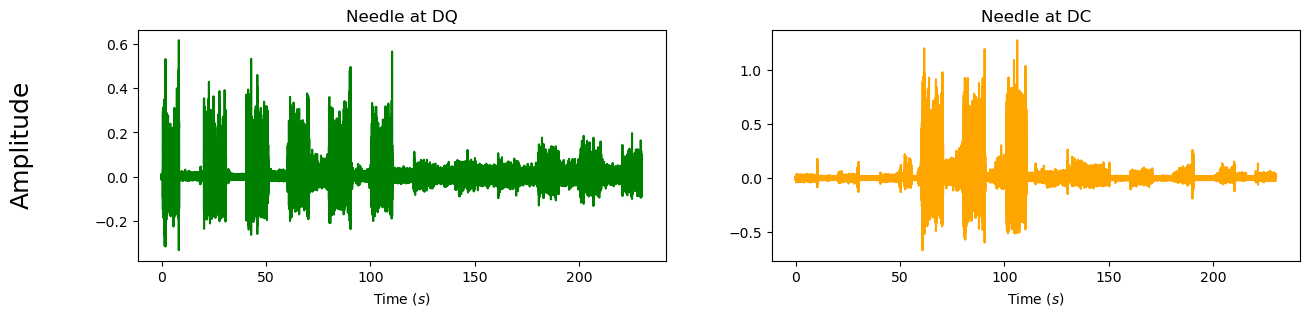

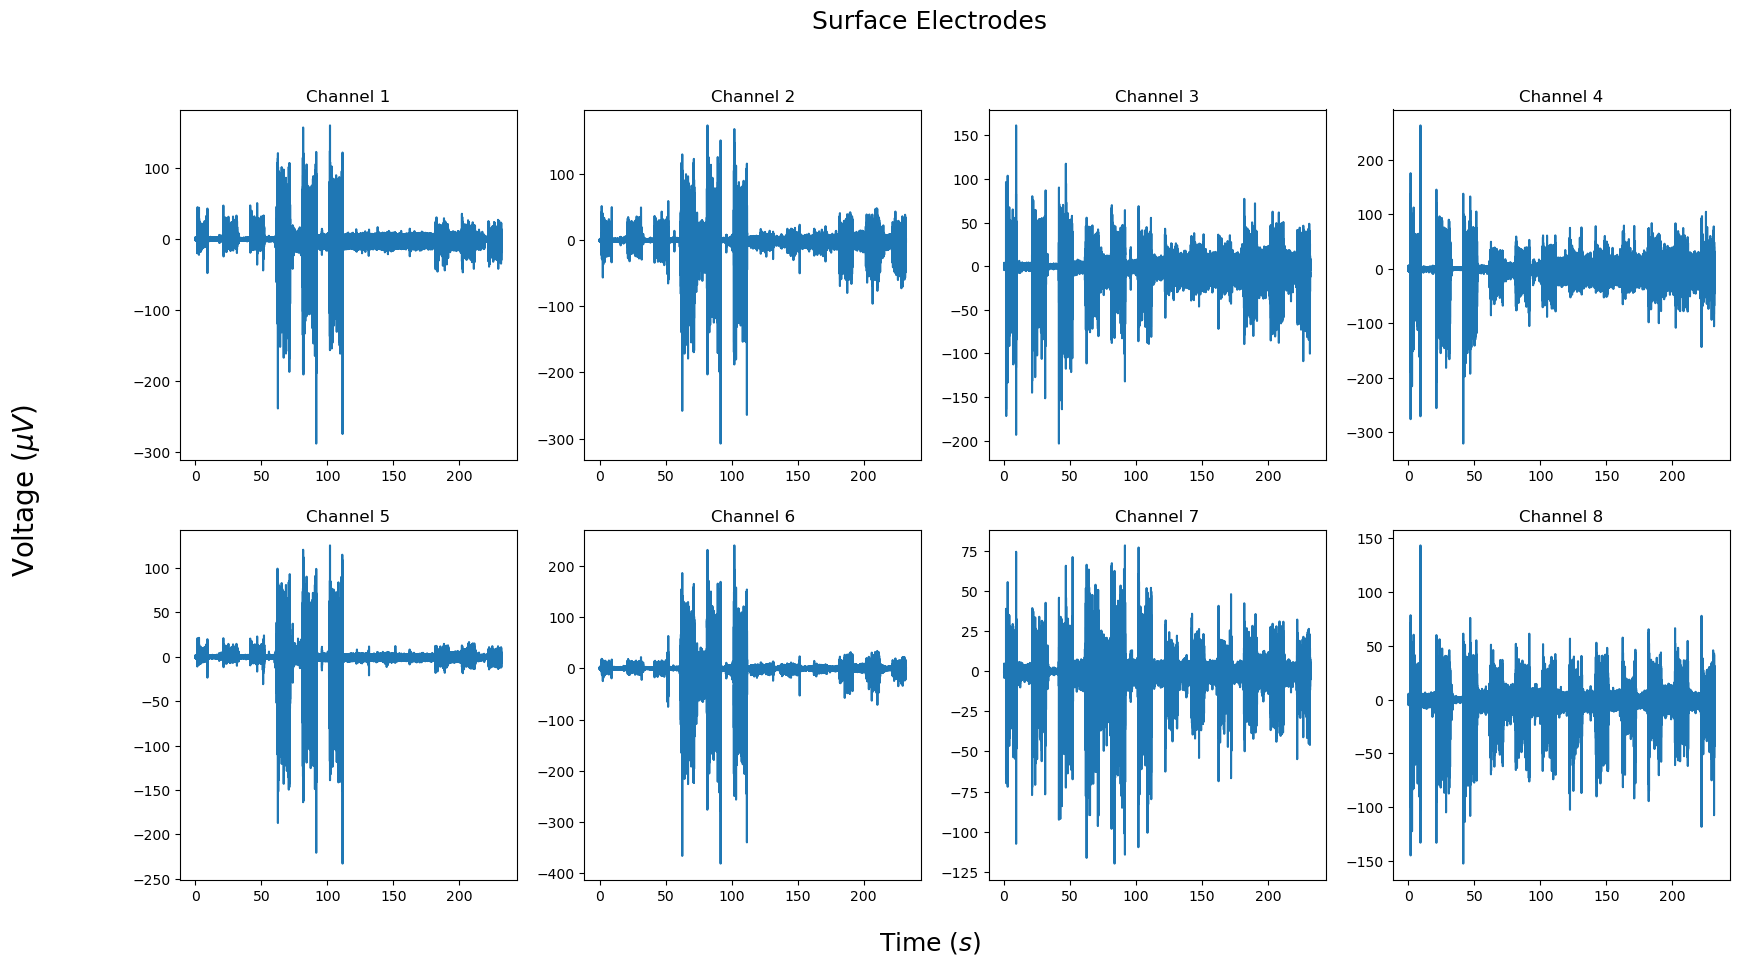

In [6]:
flr_plots.plot_time_series_needle( NIsoF_Data[2,:], NIsoF_Data[3,:], x_n)
flr_plots.plot_time_series_surface2(SIsoF_Data[2], x_s)

### Rectifying Signals with RMS 

In [8]:
# There are many methods for rectifying EMG. I opted for a moving window convulation since this worked best 
# with little aliasing on the neck Laryngeal EMG data. 
# Futher details can be found in the processing py file. 

window = 1 #this window is in samples, so a window of 1 is 1 sample. For a window of 1 sec, you'd need the sampling rate 
DQ_RMS = flr_processing.find_smoothRMS_1CH(NIsoF_Data[2,:],window)
DC_RMS = flr_processing.find_smoothRMS_1CH(NIsoF_Data[3,:],window)
S_RMS1 = flr_processing.find_smoothRMS_MultiCH(SIsoF_Data[2,:,:],window)
S_RMS2 = flr_processing.find_smoothRMS_MultiCH(SIsoF_Data[3,:,:],window)

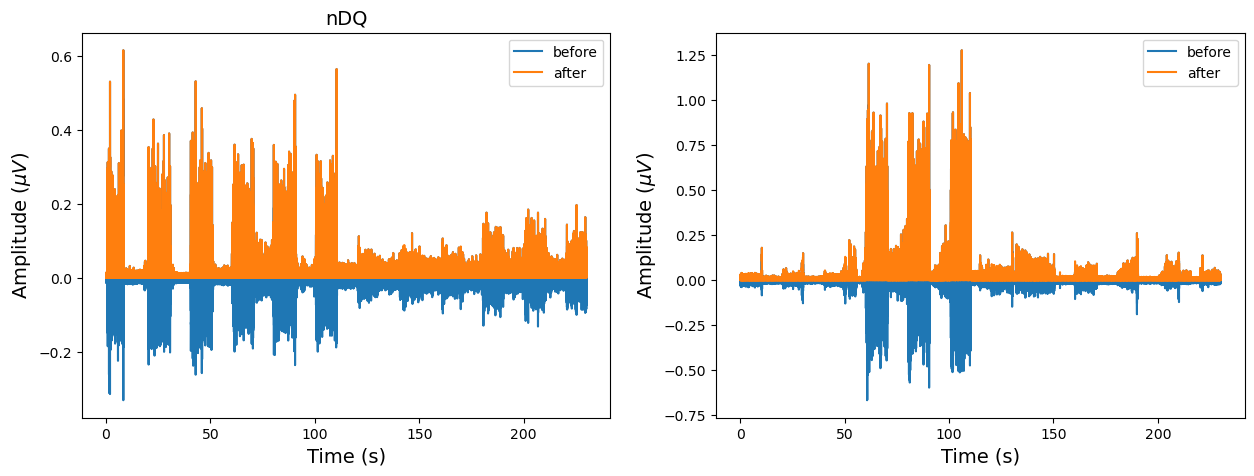

In [9]:
flr_plots.plot_2_comparisons(x_n, NIsoF_Data[2,:], DQ_RMS, NIsoF_Data[3,:], DC_RMS, 'nDQ', 'nDC')

### Creating an Envelope of the Data

In [11]:
# Generating an envelope is essentially a low-pass filter. 
# Further details can be found in the processing py file. 
cutoff = 1 
filterorder = 4

DQ_Env = flr_processing.get_needle_envelope(DQ_RMS, cutoff, fs1, filterorder)
DC_Env = flr_processing.get_needle_envelope(DC_RMS, cutoff, fs1, filterorder)
S_Env1 = flr_processing.get_surface_envelope(S_RMS1, cutoff, fs2, filterorder)
S_Env2 = flr_processing.get_surface_envelope(S_RMS2, cutoff, fs2, filterorder)

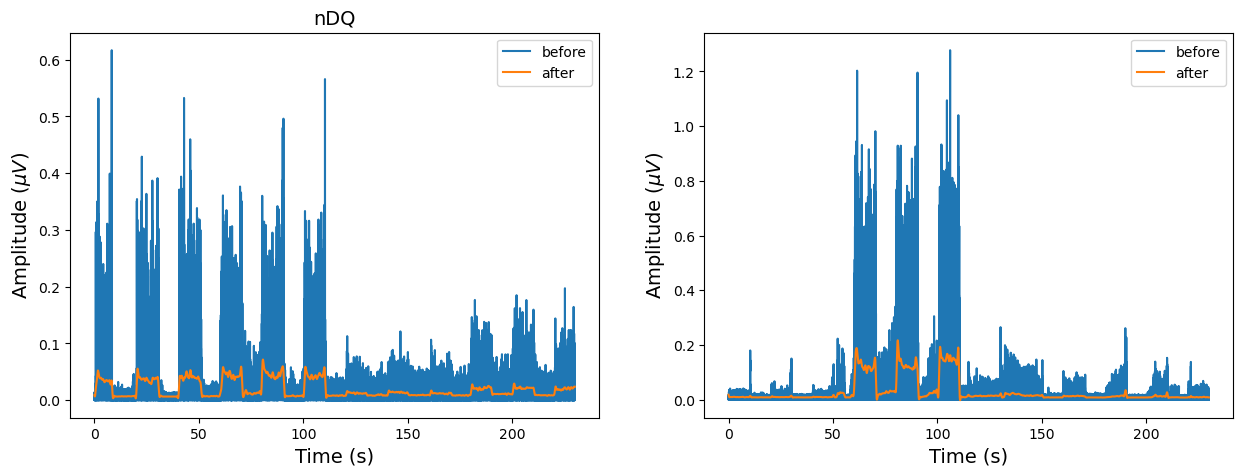

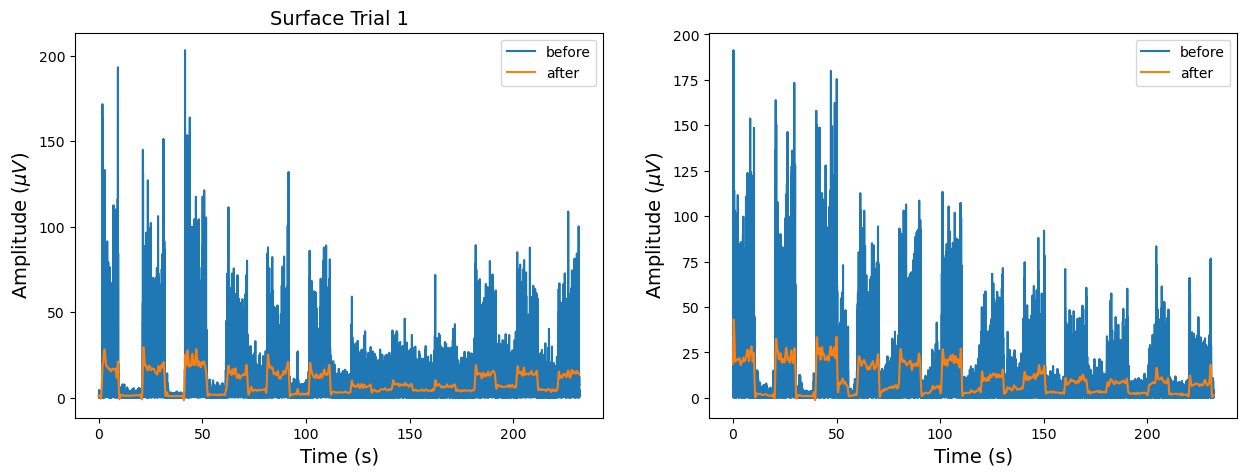

In [12]:
flr_plots.plot_2_comparisons(x_n, DQ_RMS, DQ_Env, DC_RMS, DC_Env, 'nDQ', 'nDC')
flr_plots.plot_2_comparisons(x_s, S_RMS1[2], S_Env1[2], S_RMS2[2], S_Env2[2], 'Surface Trial 1', 'Surface Trial 2')

### Converting out data into Binary O and 1 

In [14]:
## Get the baseline from 10 to 17 seconds. Ideally I would prefer to get the baseline from an entire 
# recording where the subject is at rest. In other words, there is no movement or task. I did not do 
# that here because the data was so clean, it was good enough for this demonstration. 

bs_st = 10 
bs_sp = 17 
sigma = 2

DC_b = flr_processing.needle_baseline(DC_Env, fs1, bs_st, bs_sp, sigma)
DQ_b = flr_processing.needle_baseline(DQ_Env, fs1, bs_st, bs_sp, sigma)
S_b12 = flr_processing.surface_baseline(S_RMS1, fs2, bs_st, bs_sp, sigma)

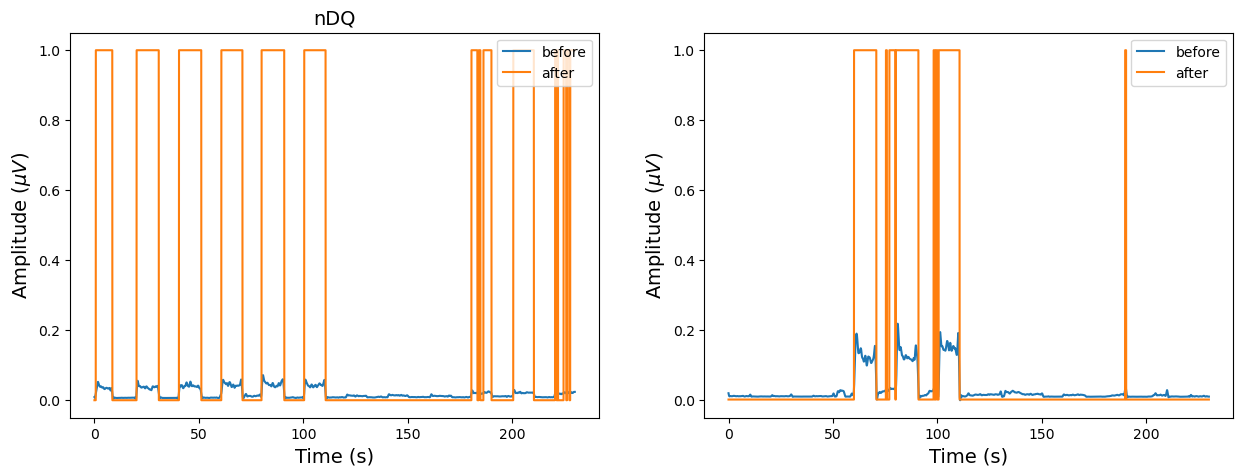

In [15]:
# Assigning 0's and 1's using the baseline as a threshold. 
DQ_01 = flr_processing.needle_01append(DQ_Env, DQ_b)
DC_01 = flr_processing.needle_01append(DC_Env, DC_b)
S1_01 = flr_processing.surface_01append(S_Env1)
S2_01 = flr_processing.surface_01append(S_Env2)

flr_plots.plot_2_comparisons(x_n, DQ_Env, DQ_01, DC_Env, DC_01, 'nDQ', 'nDC')


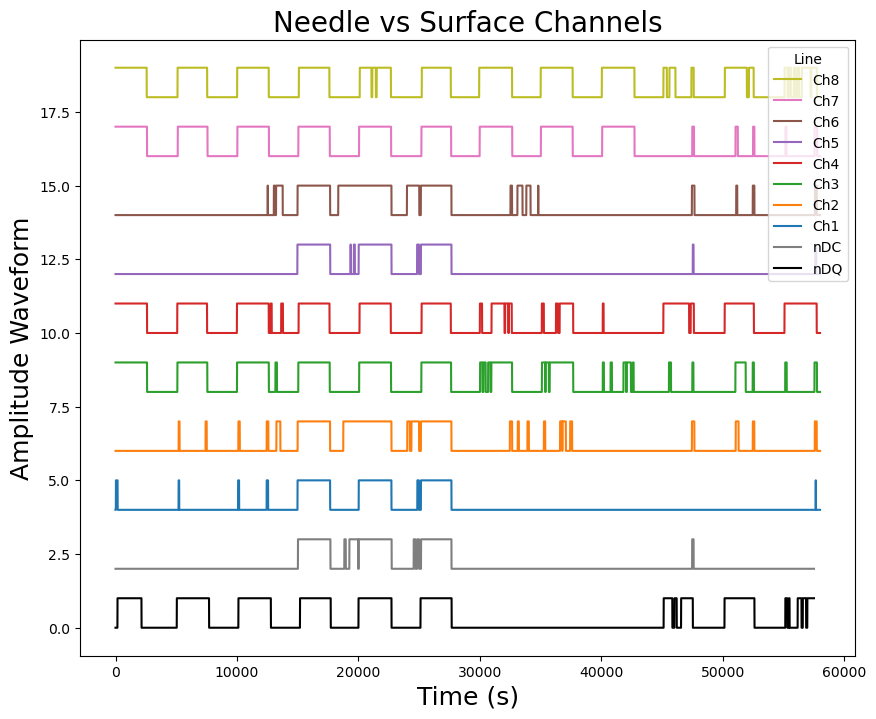

In [16]:
# Note that the two datasets (needle and surface) have different sampling rates. 
# In order to model and plot both datasets, I had to downsample the data. 
# I simply took every 16th sample. I did not use the decimate function because after doing so
# the data was no longer binary. Decimation should be done before hand in the pre-processing, 
# but for this experiment, I didn't see the need. 

downsample = 16 
color_arr = ['C0','C1','C2','C3','C4','C5','C6','C8']
label_arr = ['Ch1','Ch2','Ch3','Ch4','Ch5','Ch6','Ch7','Ch8']
flr_plots.plot_all_binary(DQ_01, DC_01, downsample, S2_01, color_arr, label_arr)

## Logistic Regression Analysis 

In [18]:
# Define predictors and target
# Once again here I downsample the data by taking every 16th count, but then I pad the edges with 0's so that 
# the lengths match. 
X = np.transpose(S2_01)
y_DQ = np.pad(DQ_01[0:-1:16], 250, mode='edge')
y_DC = np.pad(DC_01[0:-1:16], 250, mode='edge')

DQ_LR = flr_logistic_regression.logistic_regression_analysis(X, y_DQ)
DC_LR = flr_logistic_regression.logistic_regression_analysis(X, y_DC)



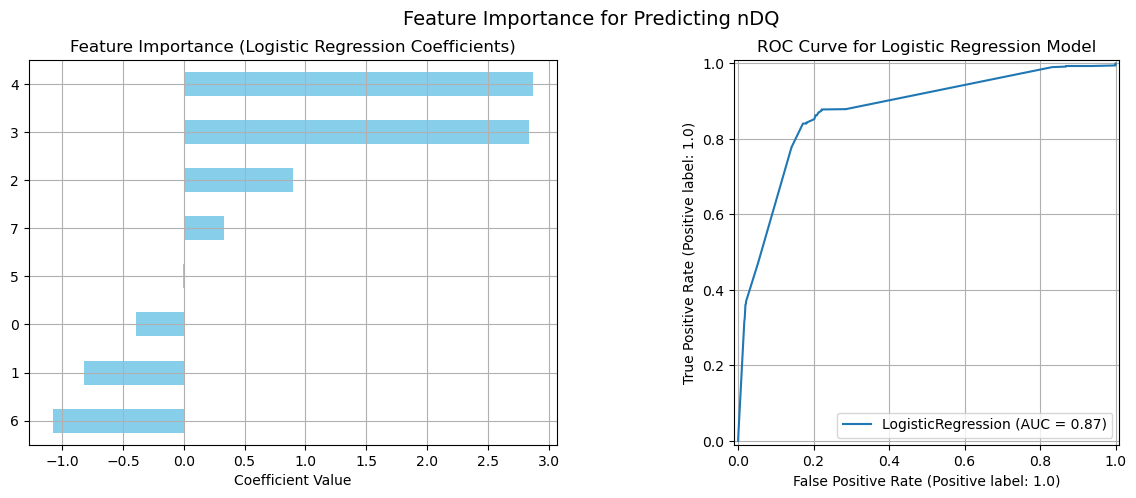

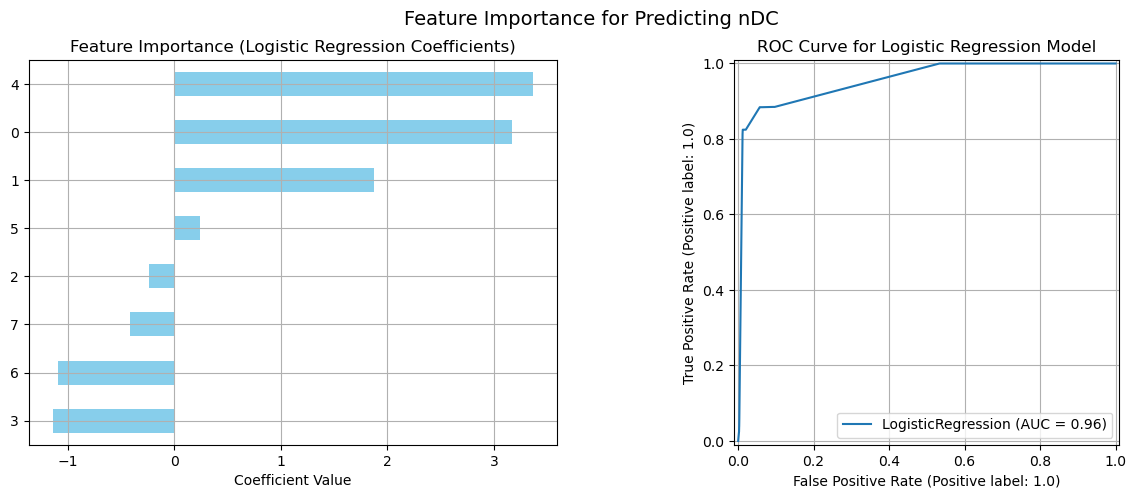

In [19]:
flr_plots.plot_feature_importance_ROC(DQ_LR,'Feature Importance for Predicting nDQ')
flr_plots.plot_feature_importance_ROC(DC_LR,'Feature Importance for Predicting nDC')

In [20]:
# Here I am creating a dictionary of the data I want to plot just so I can easily loop through it. 
data_to_plot = {'DQ': {'model_coef': DQ_LR['model_coefficients'].values.round(2),
                      'plot_title': "Feature Importance for nDQ"},
                'DC': {'model_coef': DC_LR['model_coefficients'].values.round(2), 
                      'plot_title': "Feature Importance for nDC"}
               }
# Labels is used to annotate the heat map for clarity. 
labels = [['Ch1','Ch5'],['Ch2', 'Ch6'],['Ch3','Ch7'], ['Ch4','Ch8']]

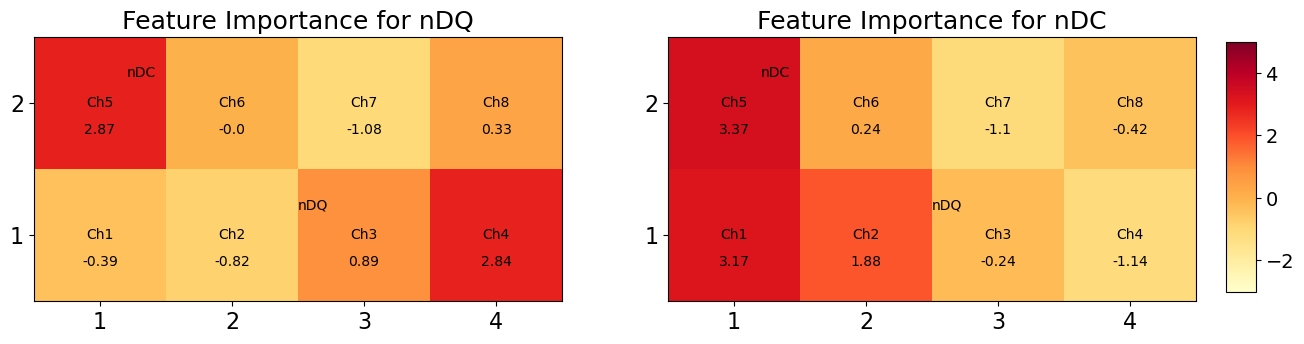

In [21]:
flr_plots.generate_heat_map(data_to_plot, labels)
#plt.savefig("Feature_Importance_EnergyMap.png", dpi = 300)